In [1]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(lme4))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(variancePartition))
suppressPackageStartupMessages(library(edgeR))
suppressPackageStartupMessages(library(doParallel))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

Warning message:
“package ‘stringr’ was built under R version 4.3.2”


In [2]:
d = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/t1_Olink_QCed.csv')
f = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/t2_Olink_QCed.csv')
protein_info = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv')
protein_info = subset(protein_info, select = -c(MissingFreq, Panel, Panel_Lot_Nr, Normalization, ExploreVersion))
d2 <- inner_join(d, protein_info, by = "OlinkID")
f2 <- inner_join(f, protein_info, by = "OlinkID")
head(d2)
head(f2)

SampleID,OlinkID,LOD,NPX,QC_Warning,Assay_Warning,belowLOD,status,UniProt,Assay
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>
Sample_1054,OID20049,-0.3111,-0.4295,PASS,PASS,TRUE,belowLOD,P16860,NPPB
Sample_638,OID20049,-0.3111,3.0496,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_945,OID20049,-0.3111,-0.1432,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_864,OID20049,-0.3111,2.6965,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_531,OID20049,-0.3111,0.4837,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_957,OID20049,-0.3111,2.7744,PASS,PASS,FALSE,ok,P16860,NPPB


SampleID,OlinkID,LOD,NPX,QC_Warning,Assay_Warning,belowLOD,status,UniProt,Assay
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>
Sample_283,OID20049,-0.3111,-0.0446,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_709,OID20049,-0.3111,1.0418,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_1372,OID20049,-0.3111,1.4322,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_1380,OID20049,-0.3111,-0.4819,PASS,PASS,TRUE,belowLOD,P16860,NPPB
Sample_1070,OID20049,-0.3111,3.3083,PASS,PASS,FALSE,ok,P16860,NPPB
Sample_266,OID20049,-0.3111,1.0342,PASS,PASS,FALSE,ok,P16860,NPPB


In [3]:
comm_proteins <- intersect(d2$Olink, f2$Olink)
d2 <- d2[d2$OlinkID %in% comm_proteins]
f2 <- f2[f2$OlinkID %in% comm_proteins]# For use later
assay.ids = unique(d2[,.(OlinkID, UniProt, Assay)])

In [4]:
options(width=300)
covar1 = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/T1_final_covariates.csv')
covar2 = fread('/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/T2_final_covariates.csv')

covar1$SubjectID <- gsub("SubjectID_", "", covar1$SubjectID)
covar2$SubjectID <- gsub("SubjectID_", "", covar2$SubjectID)
covar1[,`:=`(
    Gender=as.factor(Gender),
    Site=as.factor(Site))]

covar2[,`:=`(
    Gender=as.factor(Gender),
    Site=as.factor(Site))]

#adding case-control information
healthy <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/3_healthy_pQTLs/subject_ids.txt")
prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/5_prediabetic_pQTLs/subject_ids.txt")
diabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/phenotype-data/4_diabetic_pQTLs/subject_ids.txt")

# healthy <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/remission_clean.txt")
# prediabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/prediabetes_clean.txt")
# diabetes <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/differential_expression_analysis/new_definition_analysis/AW_Patient list/diabetic_clean.txt")
# covar[grepl('FB', SampleID), sample.type:='control']
summary(covar1)
summary(covar2)

   SampleID          SubjectID              Age             Age2      Gender     MeanNPX              Site      storage_time   
 Length:831         Length:831         Min.   :23.00   Min.   : 529   m:357   Min.   :-0.50246   TUE    :285   Min.   : 0.910  
 Class :character   Class :character   1st Qu.:52.50   1st Qu.:2756   w:474   1st Qu.:-0.10905   DRE    :181   1st Qu.: 7.730  
 Mode  :character   Mode  :character   Median :60.00   Median :3600           Median : 0.03903   Charite: 86   Median : 8.530  
                                       Mean   :59.23   Mean   :3606           Mean   : 0.04564   TUM    : 67   Mean   : 8.536  
                                       3rd Qu.:67.00   3rd Qu.:4489           3rd Qu.: 0.17739   UKH    : 66   3rd Qu.: 9.660  
                                       Max.   :80.00   Max.   :6400           Max.   : 1.16411   LEI    : 44   Max.   :11.260  
                                                                                                 (Other)

   SampleID          SubjectID              Age             Age2      Gender     MeanNPX              Site      storage_time  
 Length:458         Length:458         Min.   :27.00   Min.   : 729   m:211   Min.   :-0.51080   TUE    :137   Min.   :0.670  
 Class :character   Class :character   1st Qu.:54.00   1st Qu.:2916   w:247   1st Qu.:-0.11218   DRE    :125   1st Qu.:1.490  
 Mode  :character   Mode  :character   Median :61.00   Median :3721           Median : 0.01579   Charite: 40   Median :2.260  
                                       Mean   :60.22   Mean   :3711           Mean   : 0.03812   TUM    : 36   Mean   :2.513  
                                       3rd Qu.:67.00   3rd Qu.:4489           3rd Qu.: 0.16522   LEI    : 35   3rd Qu.:3.667  
                                       Max.   :80.00   Max.   :6400           Max.   : 1.05790   LMU    : 27   Max.   :5.160  
                                                                                                 (Other): 58   

In [5]:
healthy$status <- rep("healthy", length(healthy$V1))
prediabetes$status <- rep("prediabetes", length(prediabetes$V1))
diabetes$status <- rep("diabetes", length(diabetes$V1))
t2d_status <- rbind(healthy, prediabetes, diabetes)
colnames(t2d_status)[colnames(t2d_status) == "V1"] <- "SubjectID"

In [6]:
covar1$SubjectID = as.numeric(covar1$SubjectID)
t2d_status$SubjectID = as.numeric(t2d_status$SubjectID)
covar1 <- inner_join(covar1, t2d_status, by = "SubjectID")
head(covar1)

covar2$SubjectID = as.numeric(covar2$SubjectID)
t2d_status$SubjectID = as.numeric(t2d_status$SubjectID)
covar2 <- inner_join(covar2, t2d_status, by = "SubjectID")
head(covar2)

SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>
Sample_1054,45209,59,3481,w,0.0649311663,DIF,7.44,diabetes
Sample_531,20022,62,3844,m,0.2059205280,DRE,9.99,prediabetes
Sample_154,3751,57,3249,m,0.0006529157,TUE,8.72,healthy
Sample_1063,45233,65,4225,w,0.4563622931,DIF,7.25,prediabetes
Sample_1338,70083,47,2209,w,0.3378155240,LEI,7.41,healthy
Sample_957,40254,67,4489,w,0.0259442868,Charite,8.05,prediabetes


SampleID,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status
<chr>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>
Sample_1362,70047,63,3969,m,0.02286598,LEI,1.71,diabetes
Sample_283,3266,66,4356,w,-0.11514891,TUE,4.21,healthy
Sample_709,20022,62,3844,m,0.09212044,DRE,3.93,prediabetes
Sample_1010,40254,67,4489,w,0.12119739,Charite,1.94,prediabetes
Sample_324,263,67,4489,w,-0.05120503,TUE,3.43,healthy
Sample_728,20062,41,1681,m,0.20118297,DRE,3.78,diabetes


#### Time point 1 data

In [7]:
d2$OlinkID <- paste0(d2$OlinkID,"_baseline")
d2 <- subset(d2, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status, UniProt, Assay))
head(d2)

SampleID,OlinkID,NPX
<chr>,<chr>,<dbl>
Sample_1054,OID20049_baseline,-0.4295
Sample_638,OID20049_baseline,3.0496
Sample_945,OID20049_baseline,-0.1432
Sample_864,OID20049_baseline,2.6965
Sample_531,OID20049_baseline,0.4837
Sample_957,OID20049_baseline,2.7744


In [8]:
wide = reshape(d2, idvar='SampleID', timevar='OlinkID', direction='wide')
colnames(wide) = sub('NPX.', '', colnames(wide))
head(wide)

SampleID,OID20049_baseline,OID20050_baseline,OID20051_baseline,OID20052_baseline,OID20053_baseline,OID20054_baseline,OID20055_baseline,OID20056_baseline,OID20057_baseline,⋯,OID31515_baseline,OID31516_baseline,OID31517_baseline,OID31519_baseline,OID31520_baseline,OID31522_baseline,OID31523_baseline,OID31524_baseline,OID31525_baseline,OID31526_baseline
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sample_1054,-0.4295,2.2332,-0.2035,0.8141,-0.2947,0.0010,0.0075,1.3662,0.0017,⋯,0.3141,0.3387,0.2751,0.2012,-0.0134,-0.1955,-0.0844,-0.2259,0.2218,0.2742
Sample_638,3.0496,3.1932,-0.0820,1.2323,1.2891,0.3166,0.6649,0.4889,1.0037,⋯,-0.3346,0.3591,0.0520,0.1820,-0.0601,0.8159,-0.4172,0.2453,-0.1116,0.6095
Sample_945,-0.1432,-0.3150,0.2464,-0.1802,0.6848,0.1664,0.6367,-1.4581,1.7224,⋯,0.3884,-0.0893,-0.3154,0.1956,-0.1443,0.2198,-0.1734,0.0778,-0.0377,-0.2549
Sample_864,2.6965,3.2767,1.6944,-1.0908,0.5664,0.3165,-0.1042,0.1773,1.1184,⋯,-0.0054,-0.3176,-0.2948,-0.4890,0.2946,-0.5403,-0.1199,-0.4337,-0.2229,0.0101
Sample_531,0.4837,2.2003,0.3650,1.2095,1.2211,0.2689,0.3952,-0.5941,-0.6117,⋯,-0.2280,-0.1316,-0.1526,-0.4059,0.9708,0.1693,2.5141,0.8705,0.1055,0.9530
Sample_957,2.7744,0.4617,-0.3480,0.2375,0.2473,-0.3321,-1.1745,-0.1185,-0.9615,⋯,-0.0536,-0.0709,0.2547,-0.7094,-0.1136,-0.8140,0.2796,-0.2178,-0.0511,0.0760


In [9]:
wide11 <- inner_join(wide, covar1, by = "SampleID")
data_t1 <- wide11
wide11 <- subset(wide11, select = -c(SampleID, Age, Age2, Gender, status, Site))
colnames(wide11)[colnames(wide11) == "MeanNPX"] <- "MeanNPX_baseline"
colnames(wide11)[colnames(wide11) == "storage_time"] <- "storage_time_baseline"
head(wide11)
#wide11 <- wide11[wide11$SubjectID %in% covar2$SubjectID]

OID20049_baseline,OID20050_baseline,OID20051_baseline,OID20052_baseline,OID20053_baseline,OID20054_baseline,OID20055_baseline,OID20056_baseline,OID20057_baseline,OID20061_baseline,⋯,OID31519_baseline,OID31520_baseline,OID31522_baseline,OID31523_baseline,OID31524_baseline,OID31525_baseline,OID31526_baseline,SubjectID,MeanNPX_baseline,storage_time_baseline
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.4295,2.2332,-0.2035,0.8141,-0.2947,0.0010,0.0075,1.3662,0.0017,-0.1252,⋯,0.2012,-0.0134,-0.1955,-0.0844,-0.2259,0.2218,0.2742,45209,0.06493117,7.44
3.0496,3.1932,-0.0820,1.2323,1.2891,0.3166,0.6649,0.4889,1.0037,-0.0514,⋯,0.1820,-0.0601,0.8159,-0.4172,0.2453,-0.1116,0.6095,20214,0.25251820,8.16
2.6965,3.2767,1.6944,-1.0908,0.5664,0.3165,-0.1042,0.1773,1.1184,0.1375,⋯,-0.4890,0.2946,-0.5403,-0.1199,-0.4337,-0.2229,0.0101,30043,0.09637979,8.47
0.4837,2.2003,0.3650,1.2095,1.2211,0.2689,0.3952,-0.5941,-0.6117,0.5153,⋯,-0.4059,0.9708,0.1693,2.5141,0.8705,0.1055,0.9530,20022,0.20592053,9.99
2.7744,0.4617,-0.3480,0.2375,0.2473,-0.3321,-1.1745,-0.1185,-0.9615,0.0645,⋯,-0.7094,-0.1136,-0.8140,0.2796,-0.2178,-0.0511,0.0760,40254,0.02594429,8.05
-0.5352,1.6607,-0.6820,-0.1322,0.3265,-0.0173,-0.2848,-0.1554,0.9939,-0.2433,⋯,-0.1076,-0.4995,-0.2933,0.6836,-0.3780,-0.0541,0.1102,3161,-0.12739200,10.20


#### Time point 2 data

In [10]:
f2$OlinkID <- paste0(f2$OlinkID,"_post_int")
f2 <- subset(f2, select = -c(LOD, QC_Warning, Assay_Warning, belowLOD, status, UniProt, Assay))
head(f2)

SampleID,OlinkID,NPX
<chr>,<chr>,<dbl>
Sample_283,OID20049_post_int,-0.0446
Sample_709,OID20049_post_int,1.0418
Sample_1372,OID20049_post_int,1.4322
Sample_1380,OID20049_post_int,-0.4819
Sample_1070,OID20049_post_int,3.3083
Sample_266,OID20049_post_int,1.0342


In [11]:
wide2 = reshape(f2, idvar='SampleID', timevar='OlinkID', direction='wide')
colnames(wide2) = sub('NPX.', '', colnames(wide2))
head(wide2)

SampleID,OID20049_post_int,OID20050_post_int,OID20051_post_int,OID20052_post_int,OID20053_post_int,OID20054_post_int,OID20055_post_int,OID20056_post_int,OID20057_post_int,⋯,OID31515_post_int,OID31516_post_int,OID31517_post_int,OID31519_post_int,OID31520_post_int,OID31522_post_int,OID31523_post_int,OID31524_post_int,OID31525_post_int,OID31526_post_int
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sample_283,-0.0446,0.1103,0.0666,-0.9575,-0.0202,0.3206,-1.1147,1.4496,0.2679,⋯,-0.0998,0.1303,-0.2000,-0.7226,-0.1246,-0.4010,0.4860,0.0042,-0.0462,-0.8690
Sample_709,1.0418,1.4205,1.2432,1.8263,0.7651,0.4496,-2.0585,-0.6158,-0.1391,⋯,-0.3155,-0.0730,-0.7531,-0.3185,0.2952,-1.1527,-0.3187,0.2656,-0.2061,0.6418
Sample_1372,1.4322,-0.5981,2.9903,0.0049,0.3582,-0.5685,0.5152,0.0292,0.0004,⋯,-0.0604,-0.0566,-0.1994,0.9010,1.7871,0.4281,2.2784,-0.1199,0.0586,-0.1179
Sample_1380,-0.4819,-0.7250,-1.0798,-0.8957,-1.1597,0.3099,-2.1270,-0.0189,0.2817,⋯,-0.2209,-0.5735,-0.4070,-0.2889,-0.1175,-0.4548,-0.1454,-0.3436,-0.0135,-0.7351
Sample_1070,3.3083,2.0013,-0.6610,0.6755,0.2157,-0.4277,0.3925,-0.0127,0.5972,⋯,-0.0631,0.4076,-0.3192,0.0532,0.2507,0.0249,2.1671,0.1415,-0.0407,0.4699
Sample_266,1.0342,-2.0021,0.0416,-0.9096,-0.8228,-2.5367,-0.7544,-0.1618,0.2675,⋯,-0.2623,-0.4307,-0.2851,-0.2028,-0.0842,-1.8051,-0.6303,-0.2179,-0.1295,-0.8077


In [12]:
wide22 <- inner_join(wide2, covar2, by = "SampleID")
data_t2 <- wide22
wide22 <- subset(wide22, select = -c(SampleID))
colnames(wide22)[colnames(wide22) == "MeanNPX"] <- "MeanNPX_post_int"
colnames(wide22)[colnames(wide22) == "storage_time"] <- "storage_time_post_int"
head(wide22)

OID20049_post_int,OID20050_post_int,OID20051_post_int,OID20052_post_int,OID20053_post_int,OID20054_post_int,OID20055_post_int,OID20056_post_int,OID20057_post_int,OID20061_post_int,⋯,OID31525_post_int,OID31526_post_int,SubjectID,Age,Age2,Gender,MeanNPX_post_int,Site,storage_time_post_int,status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>
-0.0446,0.1103,0.0666,-0.9575,-0.0202,0.3206,-1.1147,1.4496,0.2679,-0.0095,⋯,-0.0462,-0.8690,3266,66,4356,w,-0.11514891,TUE,4.21,healthy
1.0418,1.4205,1.2432,1.8263,0.7651,0.4496,-2.0585,-0.6158,-0.1391,-0.3001,⋯,-0.2061,0.6418,20022,62,3844,m,0.09212044,DRE,3.93,prediabetes
1.4322,-0.5981,2.9903,0.0049,0.3582,-0.5685,0.5152,0.0292,0.0004,3.8547,⋯,0.0586,-0.1179,70078,60,3600,m,0.41756693,LEI,1.34,prediabetes
-0.4819,-0.7250,-1.0798,-0.8957,-1.1597,0.3099,-2.1270,-0.0189,0.2817,-0.5362,⋯,-0.0135,-0.7351,70083,47,2209,w,-0.23220840,LEI,1.14,healthy
3.3083,2.0013,-0.6610,0.6755,0.2157,-0.4277,0.3925,-0.0127,0.5972,0.1117,⋯,-0.0407,0.4699,45233,65,4225,w,0.08164970,DIF,0.79,prediabetes
1.0342,-2.0021,0.0416,-0.9096,-0.8228,-2.5367,-0.7544,-0.1618,0.2675,-0.7078,⋯,-0.1295,-0.8077,2912,69,4761,m,-0.18973065,TUE,4.96,prediabetes


### Combining baseline and follow up datasets

In [13]:
#Creating final dataframe combining time point 1 and 2 datasets 
final_df <- inner_join(wide11, wide22, by = "SubjectID")

In [14]:
# Restructuring the data to run the model
suppressPackageStartupMessages(library(tidyr))
long_data <- final_df %>%
  pivot_longer(
    cols = starts_with("OID"),                # Select protein columns
    names_to = c(".value", "Timepoint"),          # Extract values for each protein and timepoint
    names_sep = "_",                              # Split based on the underscore separator
    values_drop_na = TRUE                         # Drop any NA values if needed
  ) %>%
  pivot_longer(
    cols = starts_with("status"),         # Handle DiabetesStatus columns
    names_to = "status",                  # New column for DiabetesStatus
    #names_prefix = "DiabetesStatus_",             # Remove the prefix
    values_to = "DiabetesStatus"
  ) %>%
  mutate(Timepoint = recode(Timepoint, 
                            baseline = "Baseline", 
                            post_int = "Post-Intervention"))  # Recode timepoints


Warning message:
“Expected 2 pieces. Additional pieces discarded in 2524 rows [2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, ...].”


In [16]:
head(long_data)

SubjectID,MeanNPX_baseline,storage_time_baseline,Age,Age2,Gender,MeanNPX_post_int,Site,storage_time_post_int,Timepoint,⋯,OID31517,OID31519,OID31520,OID31522,OID31523,OID31524,OID31525,OID31526,status,DiabetesStatus
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
45209,0.06493117,7.44,59,3481,w,0.03642186,DIF-Charite,1.06,Baseline,⋯,0.2751,0.2012,-0.0134,-0.1955,-0.0844,-0.2259,0.2218,0.2742,status,diabetes
45209,0.06493117,7.44,59,3481,w,0.03642186,DIF-Charite,1.06,post,⋯,0.0788,-0.2646,-0.0025,-0.8910,-0.2886,-0.0984,-0.3005,0.1700,status,diabetes
20214,0.25251820,8.16,74,5476,m,0.22976665,DRE,2.20,Baseline,⋯,0.0520,0.1820,-0.0601,0.8159,-0.4172,0.2453,-0.1116,0.6095,status,diabetes
20214,0.25251820,8.16,74,5476,m,0.22976665,DRE,2.20,post,⋯,-0.1012,-0.5883,-0.2403,-0.2831,-1.8651,0.1722,-0.0594,0.2944,status,diabetes
30043,0.09637979,8.47,63,3969,w,0.11302234,DDZ,2.43,Baseline,⋯,-0.2948,-0.4890,0.2946,-0.5403,-0.1199,-0.4337,-0.2229,0.0101,status,prediabetes
30043,0.09637979,8.47,63,3969,w,0.11302234,DDZ,2.43,post,⋯,-0.3007,-0.5375,-0.3664,-0.8593,-0.4507,0.3097,0.0145,0.5564,status,prediabetes


### Healthy individuals

In [15]:
#Healthy individuals
healthy_data <- subset(long_data, long_data$DiabetesStatus == "healthy")
head(healthy_data)

SubjectID,MeanNPX_baseline,storage_time_baseline,Age,Age2,Gender,MeanNPX_post_int,Site,storage_time_post_int,Timepoint,⋯,OID31517,OID31519,OID31520,OID31522,OID31523,OID31524,OID31525,OID31526,status,DiabetesStatus
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3751,0.0006529157,8.72,57,3249,m,0.03805172,TUE,2.92,Baseline,⋯,0.3265,0.3516,-0.4636,-0.1593,-1.0220,-0.8727,-0.1290,-0.3969,status,healthy
3751,0.0006529157,8.72,57,3249,m,0.03805172,TUE,2.92,post,⋯,0.0106,0.0751,-0.6083,0.4670,0.1658,-0.4937,-0.2211,-0.3889,status,healthy
263,-0.2029521277,9.37,67,4489,w,-0.05120503,TUE,3.43,Baseline,⋯,-0.2247,-0.7265,0.0177,-0.6530,-0.4271,-0.3078,0.1633,-0.0476,status,healthy
263,-0.2029521277,9.37,67,4489,w,-0.05120503,TUE,3.43,post,⋯,0.1088,-1.0658,0.5186,-0.1528,0.3231,0.1093,0.1574,0.4648,status,healthy
3266,-0.0801594169,10.33,66,4356,w,-0.11514891,TUE,4.21,Baseline,⋯,0.0520,-0.1693,-0.2748,-0.2859,0.2429,-0.2397,0.0313,-0.5142,status,healthy
3266,-0.0801594169,10.33,66,4356,w,-0.11514891,TUE,4.21,post,⋯,-0.2000,-0.7226,-0.1246,-0.4010,0.4860,0.0042,-0.0462,-0.8690,status,healthy


In [16]:
healthy_data$Mean_NPX <- ifelse(healthy_data$Timepoint == "Baseline", healthy_data$MeanNPX_baseline, healthy_data$MeanNPX_post_int)
healthy_data <- healthy_data[, !names(healthy_data) %in% c("MeanNPX_baseline", "MeanNPX_post_int")]
healthy_data$storage_time <- ifelse(healthy_data$Timepoint == "Baseline", healthy_data$storage_time_baseline, healthy_data$storage_time_post_int)
healthy_data <- healthy_data[, !names(healthy_data) %in% c("storage_time_baseline", "storage_time_post_int")]
head(healthy_data)

SubjectID,Age,Age2,Gender,Site,Timepoint,OID20049,OID20050,OID20051,OID20052,⋯,OID31520,OID31522,OID31523,OID31524,OID31525,OID31526,status,DiabetesStatus,Mean_NPX,storage_time
<dbl>,<int>,<int>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
3751,57,3249,m,TUE,Baseline,1.0705,0.0227,-0.4312,-0.2222,⋯,-0.4636,-0.1593,-1.0220,-0.8727,-0.1290,-0.3969,status,healthy,0.0006529157,8.72
3751,57,3249,m,TUE,post,-1.6523,1.0749,-0.9714,0.2196,⋯,-0.6083,0.4670,0.1658,-0.4937,-0.2211,-0.3889,status,healthy,0.0380517228,2.92
263,67,4489,w,TUE,Baseline,4.1688,1.1224,-0.4471,-0.5486,⋯,0.0177,-0.6530,-0.4271,-0.3078,0.1633,-0.0476,status,healthy,-0.2029521277,9.37
263,67,4489,w,TUE,post,5.0527,1.0502,-0.9909,0.2978,⋯,0.5186,-0.1528,0.3231,0.1093,0.1574,0.4648,status,healthy,-0.0512050297,3.43
3266,66,4356,w,TUE,Baseline,0.0395,-1.3274,-0.7675,-0.9373,⋯,-0.2748,-0.2859,0.2429,-0.2397,0.0313,-0.5142,status,healthy,-0.0801594169,10.33
3266,66,4356,w,TUE,post,-0.0446,0.1103,0.0666,-0.9575,⋯,-0.1246,-0.4010,0.4860,0.0042,-0.0462,-0.8690,status,healthy,-0.1151489109,4.21


### Diabetic individuals

In [17]:
#Diabetic individuals
diabetic_data <- subset(long_data, long_data$DiabetesStatus == "diabetes")
head(diabetic_data)

SubjectID,MeanNPX_baseline,storage_time_baseline,Age,Age2,Gender,MeanNPX_post_int,Site,storage_time_post_int,Timepoint,⋯,OID31517,OID31519,OID31520,OID31522,OID31523,OID31524,OID31525,OID31526,status,DiabetesStatus
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
45209,0.06493117,7.44,59,3481,w,0.03642186,DIF-Charite,1.06,Baseline,⋯,0.2751,0.2012,-0.0134,-0.1955,-0.0844,-0.2259,0.2218,0.2742,status,diabetes
45209,0.06493117,7.44,59,3481,w,0.03642186,DIF-Charite,1.06,post,⋯,0.0788,-0.2646,-0.0025,-0.8910,-0.2886,-0.0984,-0.3005,0.1700,status,diabetes
20214,0.25251820,8.16,74,5476,m,0.22976665,DRE,2.20,Baseline,⋯,0.0520,0.1820,-0.0601,0.8159,-0.4172,0.2453,-0.1116,0.6095,status,diabetes
20214,0.25251820,8.16,74,5476,m,0.22976665,DRE,2.20,post,⋯,-0.1012,-0.5883,-0.2403,-0.2831,-1.8651,0.1722,-0.0594,0.2944,status,diabetes
70089,-0.14177336,7.32,55,3025,m,0.12268293,LEI,1.26,Baseline,⋯,0.1229,-0.1833,-0.1530,0.7739,-0.2312,0.0652,-0.0057,-0.2461,status,diabetes
70089,-0.14177336,7.32,55,3025,m,0.12268293,LEI,1.26,post,⋯,0.0843,0.6190,-0.2921,0.4776,1.5944,-0.1332,0.3312,-0.6494,status,diabetes


In [18]:
diabetic_data$Mean_NPX <- ifelse(diabetic_data$Timepoint == "Baseline", diabetic_data$MeanNPX_baseline, diabetic_data$MeanNPX_post_int)
diabetic_data <- diabetic_data[, !names(diabetic_data) %in% c("MeanNPX_baseline", "MeanNPX_post_int")]
diabetic_data$storage_time <- ifelse(diabetic_data$Timepoint == "Baseline", diabetic_data$storage_time_baseline, diabetic_data$storage_time_post_int)
diabetic_data <- diabetic_data[, !names(diabetic_data) %in% c("storage_time_baseline", "storage_time_post_int")]
head(diabetic_data)

SubjectID,Age,Age2,Gender,Site,Timepoint,OID20049,OID20050,OID20051,OID20052,⋯,OID31520,OID31522,OID31523,OID31524,OID31525,OID31526,status,DiabetesStatus,Mean_NPX,storage_time
<dbl>,<int>,<int>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
45209,59,3481,w,DIF-Charite,Baseline,-0.4295,2.2332,-0.2035,0.8141,⋯,-0.0134,-0.1955,-0.0844,-0.2259,0.2218,0.2742,status,diabetes,0.06493117,7.44
45209,59,3481,w,DIF-Charite,post,2.5311,1.1095,-0.5892,0.5452,⋯,-0.0025,-0.8910,-0.2886,-0.0984,-0.3005,0.1700,status,diabetes,0.03642186,1.06
20214,74,5476,m,DRE,Baseline,3.0496,3.1932,-0.0820,1.2323,⋯,-0.0601,0.8159,-0.4172,0.2453,-0.1116,0.6095,status,diabetes,0.25251820,8.16
20214,74,5476,m,DRE,post,2.6286,2.3676,0.0063,0.1375,⋯,-0.2403,-0.2831,-1.8651,0.1722,-0.0594,0.2944,status,diabetes,0.22976665,2.20
70089,55,3025,m,LEI,Baseline,-1.0071,-0.6344,-0.5029,-1.0735,⋯,-0.1530,0.7739,-0.2312,0.0652,-0.0057,-0.2461,status,diabetes,-0.14177336,7.32
70089,55,3025,m,LEI,post,0.8162,-2.3757,0.2962,-1.0235,⋯,-0.2921,0.4776,1.5944,-0.1332,0.3312,-0.6494,status,diabetes,0.12268293,1.26


### Prediabetic individuals

In [19]:
#Prediabetic individuals
prediabetic_data <- subset(long_data, long_data$DiabetesStatus == "prediabetes")
head(prediabetic_data)

SubjectID,MeanNPX_baseline,storage_time_baseline,Age,Age2,Gender,MeanNPX_post_int,Site,storage_time_post_int,Timepoint,⋯,OID31517,OID31519,OID31520,OID31522,OID31523,OID31524,OID31525,OID31526,status,DiabetesStatus
<dbl>,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
30043,0.09637979,8.47,63,3969,w,0.11302234,DDZ,2.43,Baseline,⋯,-0.2948,-0.4890,0.2946,-0.5403,-0.1199,-0.4337,-0.2229,0.0101,status,prediabetes
30043,0.09637979,8.47,63,3969,w,0.11302234,DDZ,2.43,post,⋯,-0.3007,-0.5375,-0.3664,-0.8593,-0.4507,0.3097,0.0145,0.5564,status,prediabetes
20022,0.20592053,9.99,62,3844,m,0.09212044,DRE,3.93,Baseline,⋯,-0.1526,-0.4059,0.9708,0.1693,2.5141,0.8705,0.1055,0.9530,status,prediabetes
20022,0.20592053,9.99,62,3844,m,0.09212044,DRE,3.93,post,⋯,-0.7531,-0.3185,0.2952,-1.1527,-0.3187,0.2656,-0.2061,0.6418,status,prediabetes
40254,0.02594429,8.05,67,4489,w,0.12119739,Charite,1.94,Baseline,⋯,0.2547,-0.7094,-0.1136,-0.8140,0.2796,-0.2178,-0.0511,0.0760,status,prediabetes
40254,0.02594429,8.05,67,4489,w,0.12119739,Charite,1.94,post,⋯,-0.0377,-0.3447,0.3245,-0.5812,0.7145,0.3877,0.1740,0.6387,status,prediabetes


In [20]:
prediabetic_data$Mean_NPX <- ifelse(prediabetic_data$Timepoint == "Baseline", prediabetic_data$MeanNPX_baseline, prediabetic_data$MeanNPX_post_int)
prediabetic_data <- prediabetic_data[, !names(prediabetic_data) %in% c("MeanNPX_baseline", "MeanNPX_post_int")]
prediabetic_data$storage_time <- ifelse(prediabetic_data$Timepoint == "Baseline", prediabetic_data$storage_time_baseline, prediabetic_data$storage_time_post_int)
prediabetic_data <- prediabetic_data[, !names(prediabetic_data) %in% c("storage_time_baseline", "storage_time_post_int")]
head(prediabetic_data)

SubjectID,Age,Age2,Gender,Site,Timepoint,OID20049,OID20050,OID20051,OID20052,⋯,OID31520,OID31522,OID31523,OID31524,OID31525,OID31526,status,DiabetesStatus,Mean_NPX,storage_time
<dbl>,<int>,<int>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
30043,63,3969,w,DDZ,Baseline,2.6965,3.2767,1.6944,-1.0908,⋯,0.2946,-0.5403,-0.1199,-0.4337,-0.2229,0.0101,status,prediabetes,0.09637979,8.47
30043,63,3969,w,DDZ,post,2.9620,3.6700,0.3849,-0.1443,⋯,-0.3664,-0.8593,-0.4507,0.3097,0.0145,0.5564,status,prediabetes,0.11302234,2.43
20022,62,3844,m,DRE,Baseline,0.4837,2.2003,0.3650,1.2095,⋯,0.9708,0.1693,2.5141,0.8705,0.1055,0.9530,status,prediabetes,0.20592053,9.99
20022,62,3844,m,DRE,post,1.0418,1.4205,1.2432,1.8263,⋯,0.2952,-1.1527,-0.3187,0.2656,-0.2061,0.6418,status,prediabetes,0.09212044,3.93
40254,67,4489,w,Charite,Baseline,2.7744,0.4617,-0.3480,0.2375,⋯,-0.1136,-0.8140,0.2796,-0.2178,-0.0511,0.0760,status,prediabetes,0.02594429,8.05
40254,67,4489,w,Charite,post,2.9004,0.6720,-0.2041,0.7900,⋯,0.3245,-0.5812,0.7145,0.3877,0.1740,0.6387,status,prediabetes,0.12119739,1.94


## Using Limma

#### Comparing T1 and T2 protein levels within groups: Diabetic, prediabetic and healthy

In [21]:
colnames(data_t1) <- gsub("_baseline$", "", colnames(data_t1))
colnames(data_t2) <- gsub("_post_int$", "", colnames(data_t2))
data_t1$timepoint <- rep("1", length(data_t1$SampleID))
data_t2$timepoint <- rep("2", length(data_t2$SampleID))
head(data_t1)
head(data_t2)

SampleID,OID20049,OID20050,OID20051,OID20052,OID20053,OID20054,OID20055,OID20056,OID20057,⋯,OID31526,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status,timepoint
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<chr>
Sample_1054,-0.4295,2.2332,-0.2035,0.8141,-0.2947,0.0010,0.0075,1.3662,0.0017,⋯,0.2742,45209,59,3481,w,0.06493117,DIF,7.44,diabetes,1
Sample_638,3.0496,3.1932,-0.0820,1.2323,1.2891,0.3166,0.6649,0.4889,1.0037,⋯,0.6095,20214,74,5476,m,0.25251820,DRE,8.16,diabetes,1
Sample_864,2.6965,3.2767,1.6944,-1.0908,0.5664,0.3165,-0.1042,0.1773,1.1184,⋯,0.0101,30043,63,3969,w,0.09637979,DDZ,8.47,prediabetes,1
Sample_531,0.4837,2.2003,0.3650,1.2095,1.2211,0.2689,0.3952,-0.5941,-0.6117,⋯,0.9530,20022,62,3844,m,0.20592053,DRE,9.99,prediabetes,1
Sample_957,2.7744,0.4617,-0.3480,0.2375,0.2473,-0.3321,-1.1745,-0.1185,-0.9615,⋯,0.0760,40254,67,4489,w,0.02594429,Charite,8.05,prediabetes,1
Sample_437,-0.5352,1.6607,-0.6820,-0.1322,0.3265,-0.0173,-0.2848,-0.1554,0.9939,⋯,0.1102,3161,59,3481,w,-0.12739200,TUE,10.20,prediabetes,1


SampleID,OID20049,OID20050,OID20051,OID20052,OID20053,OID20054,OID20055,OID20056,OID20057,⋯,OID31526,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status,timepoint
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<chr>
Sample_283,-0.0446,0.1103,0.0666,-0.9575,-0.0202,0.3206,-1.1147,1.4496,0.2679,⋯,-0.8690,3266,66,4356,w,-0.11514891,TUE,4.21,healthy,2
Sample_709,1.0418,1.4205,1.2432,1.8263,0.7651,0.4496,-2.0585,-0.6158,-0.1391,⋯,0.6418,20022,62,3844,m,0.09212044,DRE,3.93,prediabetes,2
Sample_1372,1.4322,-0.5981,2.9903,0.0049,0.3582,-0.5685,0.5152,0.0292,0.0004,⋯,-0.1179,70078,60,3600,m,0.41756693,LEI,1.34,prediabetes,2
Sample_1380,-0.4819,-0.7250,-1.0798,-0.8957,-1.1597,0.3099,-2.1270,-0.0189,0.2817,⋯,-0.7351,70083,47,2209,w,-0.23220840,LEI,1.14,healthy,2
Sample_1070,3.3083,2.0013,-0.6610,0.6755,0.2157,-0.4277,0.3925,-0.0127,0.5972,⋯,0.4699,45233,65,4225,w,0.08164970,DIF,0.79,prediabetes,2
Sample_266,1.0342,-2.0021,0.0416,-0.9096,-0.8228,-2.5367,-0.7544,-0.1618,0.2675,⋯,-0.8077,2912,69,4761,m,-0.18973065,TUE,4.96,prediabetes,2


In [22]:
combined_data <- rbind(data_t1, data_t2)
fwrite(data_t1, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/delta_expression_disease-status-association/input_files/data_t1.txt")
fwrite(data_t2, "/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/delta_expression_disease-status-association/input_files/data_t2.txt")

In [23]:
#expression data
healthy_dataset <- subset(combined_data, combined_data$status == "healthy")
diabetic_dataset <- subset(combined_data, combined_data$status == "diabetes")
prediabetic_dataset <- subset(combined_data, combined_data$status == "prediabetes")

healthy_expression <- healthy_dataset %>%
  select(SampleID, starts_with("OID"))
diabetic_expression <- diabetic_dataset %>%
  select(SampleID, starts_with("OID"))
prediabetic_expression <- prediabetic_dataset %>%
  select(SampleID, starts_with("OID"))

#### Healthy individuals

In [24]:
healthy_expression <- data.frame(healthy_expression)
rownames(healthy_expression) <- healthy_expression$SampleID
healthy_expression$SampleID <- NULL
expr_matrix <- as.matrix(t(healthy_expression))

In [25]:
#Covariates
healthy_covar <- healthy_dataset %>%
  select(SampleID, SubjectID, Age, Age2, Gender, MeanNPX, Site, storage_time, status, timepoint)
diabetic_covar <- diabetic_dataset %>%
  select(SampleID, SubjectID, Age, Age2, Gender, MeanNPX, Site, storage_time, status, timepoint)
prediabetic_covar <- prediabetic_dataset %>%
  select(SampleID, SubjectID, Age, Age2, Gender, MeanNPX, Site, storage_time, status, timepoint)

In [26]:
healthy_covar <- data.frame(healthy_covar)
rownames(healthy_covar) <- healthy_covar$SampleID
healthy_covar$SampleID <- NULL

In [27]:
#genes = DGEList( expr_matrix )
#design = model.matrix(as.formula("~ MeanNPX + Gender + Age + Age2 + Site + storage_time + timepoint"), data = healthy_covar)
design = model.matrix(as.formula("~ MeanNPX + storage_time + timepoint"), data = healthy_covar)
#vobj <- voom(expr_matrix, design, plot=FALSE, block=healthy_covar$SubjectID, correlation=dupcor$consensus)

In [28]:
head(healthy_covar)

,SubjectID,Age,Age2,Gender,MeanNPX,Site,storage_time,status,timepoint
,<dbl>,<int>,<int>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<chr>
Sample_154,3751,57,3249,m,0.0006529157,TUE,8.72,healthy,1
Sample_451,263,67,4489,w,-0.2029521277,TUE,9.37,healthy,1
Sample_45,3266,66,4356,w,-0.0801594169,TUE,10.33,healthy,1
Sample_1136,50031,61,3721,m,0.1714193853,UKH,8.55,healthy,1
Sample_1338,70083,47,2209,w,0.3378155240,LEI,7.41,healthy,1
Sample_21,3002,40,1600,w,-0.3826171721,TUE,10.96,healthy,1


In [29]:
dupcor <- duplicateCorrelation(expr_matrix, design, block=healthy_covar$SubjectID)
dupcor$consensus.correlation

[1] 0.5753752

In [30]:
#fitting the model
fitDupCor <- lmFit(expr_matrix, design, block=healthy_covar$SubjectID, correlation=dupcor$consensus)
fitDupCor <- eBayes(fitDupCor)

In [31]:
tt = topTable(fitDupCor, coef = "timepoint2", n = Inf, adjust.method="BH")
head(tt)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OID21364,-1.9865494,-0.32184898,-3.757415,0.0002935722,0.234347,0.07512363
OID20244,-2.4087221,-0.10285204,-3.726535,0.0003268119,0.234347,-0.01033701
OID21059,-0.9984555,0.01030306,-3.679803,0.0003839951,0.234347,-0.13871911
OID21191,-1.6818045,-0.01853367,-3.651811,0.0004226662,0.234347,-0.21506225
OID20585,1.4785822,0.08817653,3.618853,0.0004729335,0.234347,-0.30441466
OID20694,-0.9255780,-0.04338878,-3.504278,0.0006953504,0.234347,-0.61043453


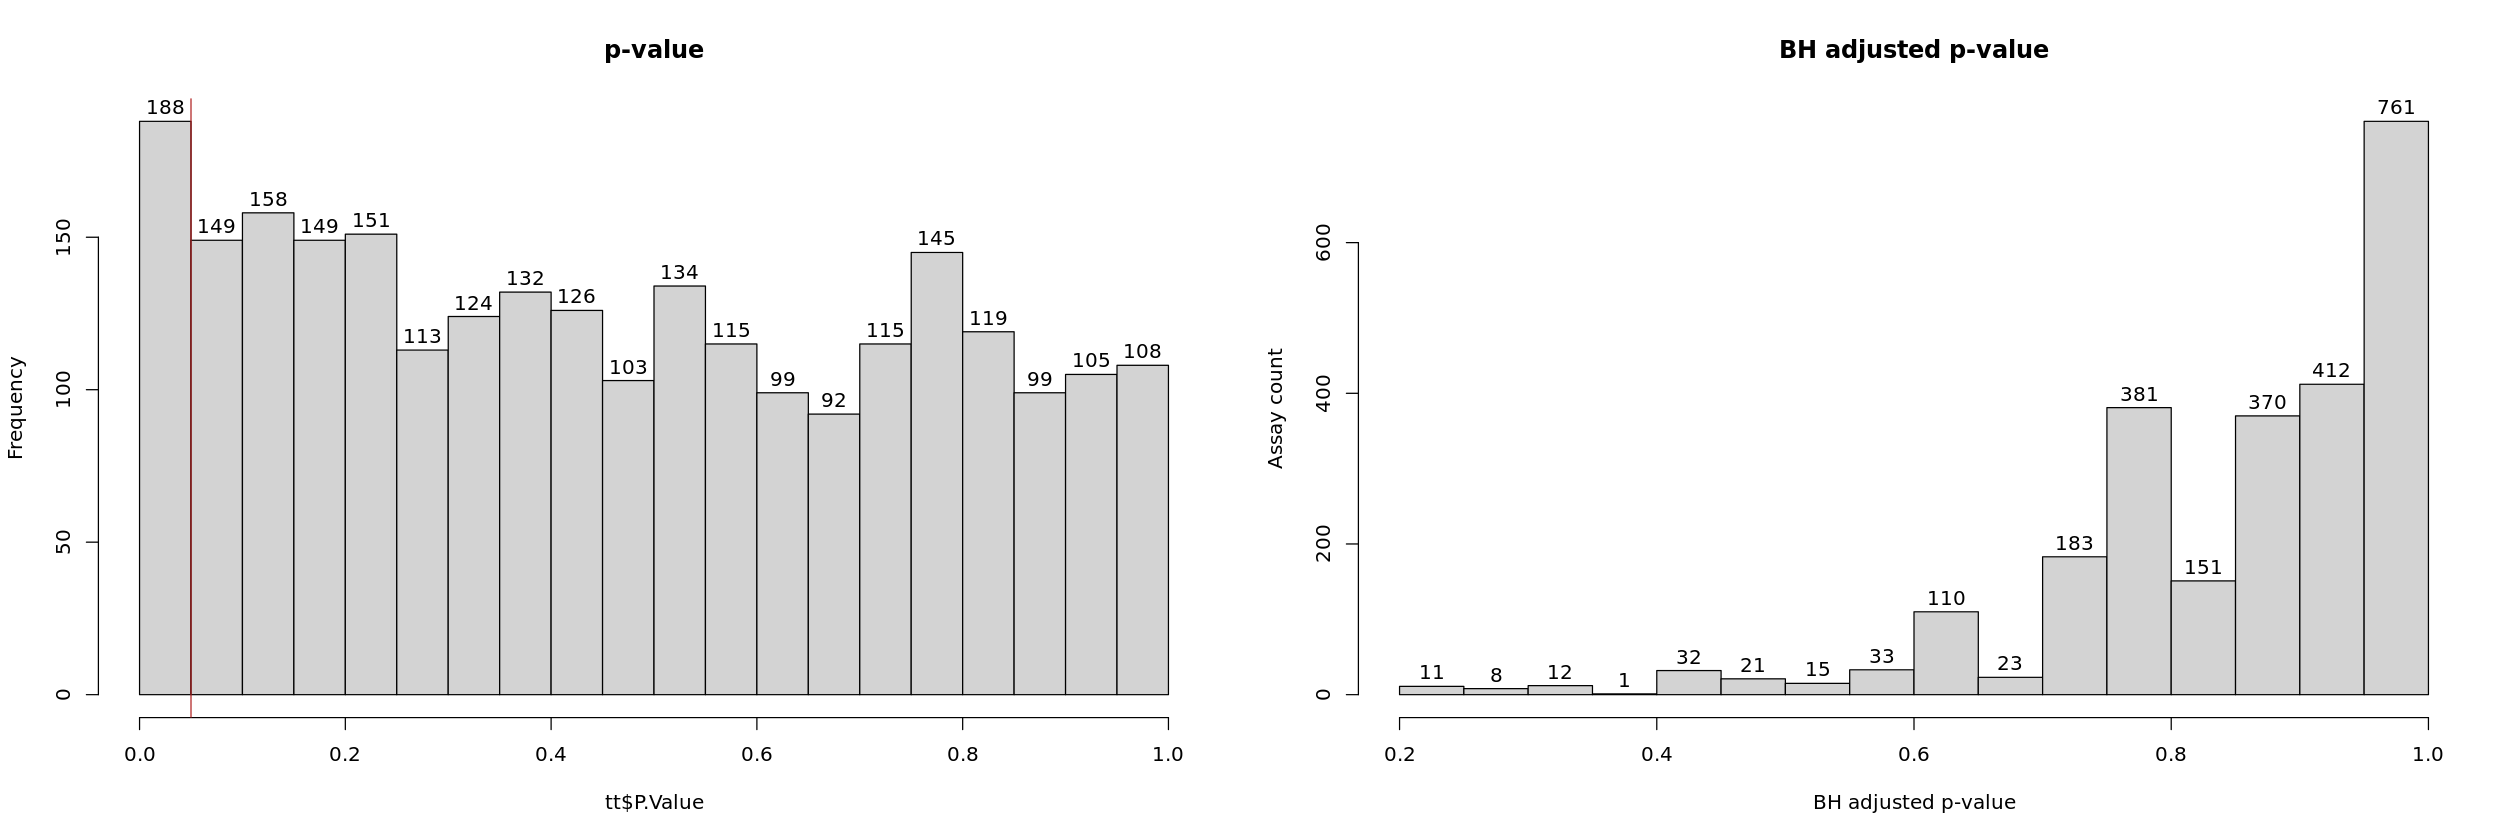

In [32]:
tt = tt[order(tt$adj.P.Val),]

tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)


options(repr.plot.width = 21, repr.plot.height = 7)
par(mfrow=c(1,2))
hist(tt$P.Value, breaks = 20, labels = TRUE, main = 'p-value')
abline(v=0.05, col='firebrick')
hist(tt$adj.P.Val, breaks = 20, labels = TRUE, main = 'BH adjusted p-value', xlab='BH adjusted p-value', ylab='Assay count')
abline(v=0.05, col='firebrick')

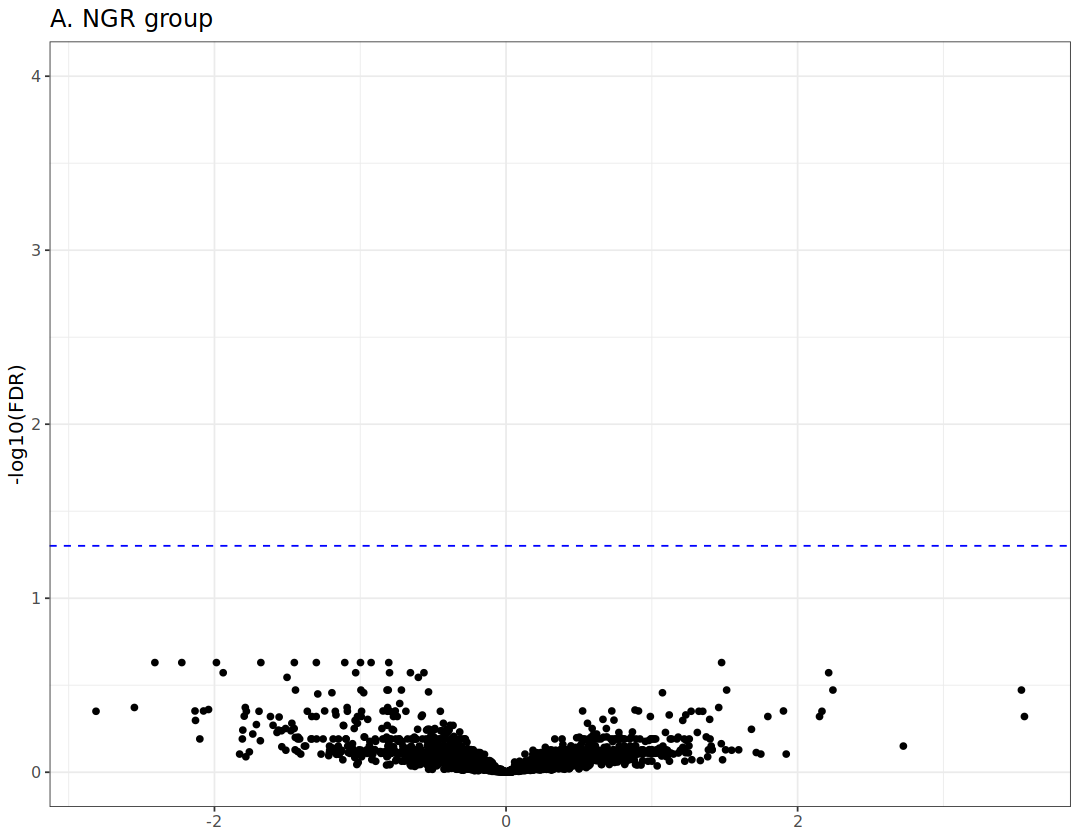

In [33]:
options(repr.plot.width=9, repr.plot.height=7)
sig.threshold = 0.05

tt2 = copy(tt)
tt2$col='grey'
tt2[tt2$adj.P.Val<sig.threshold, 'col'] = 'black'
p1 <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val), color = col)) +
    geom_point(show.legend=F) +
    geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "blue") +
    labs(
        x = NULL,
        y = "-log10(FDR)",
        title = "A. NGR group"
    ) +
    theme_bw() +
    scale_color_manual(values=c("black", "grey")) +
    theme(text = element_text(size=12)) + coord_cartesian(ylim = c(0, 4))
print(p1)

#### Diabetic individuals

In [34]:
diabetic_expression <- data.frame(diabetic_expression)
rownames(diabetic_expression) <- diabetic_expression$SampleID
diabetic_expression$SampleID <- NULL
expr_matrix <- as.matrix(t(diabetic_expression))

In [35]:
diabetic_covar <- data.frame(diabetic_covar)
rownames(diabetic_covar) <- diabetic_covar$SampleID
diabetic_covar$SampleID <- NULL

In [36]:
design = model.matrix(as.formula("~ MeanNPX + storage_time + timepoint"), data = diabetic_covar)

In [37]:
length(unique(diabetic_covar$SubjectID))

[1] 88

In [38]:
dupcor <- duplicateCorrelation(expr_matrix, design, block=diabetic_covar$SubjectID)
dupcor$consensus.correlation

[1] 0.6018093

In [39]:
#fitting the model
fitDupCor <- lmFit(expr_matrix, design, block=diabetic_covar$SubjectID, correlation=dupcor$consensus)
fitDupCor <- eBayes(fitDupCor)

In [40]:
tt = topTable(fitDupCor, coef = "timepoint2", n = Inf, adjust.method="BH")
head(tt)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OID31276,4.8223621,0.61443693,4.560054,9.584966e-06,0.02419245,2.50966272
OID20399,1.6299199,0.43331761,3.796291,2.023103e-04,0.23506426,0.18382840
OID20393,0.9033893,0.05253466,3.708828,2.793949e-04,0.23506426,-0.06071719
OID21066,-0.7615873,0.03115852,-3.487382,6.169102e-04,0.38228969,-0.65866199
OID20611,-0.5453541,0.04193693,-3.342753,1.014562e-03,0.38228969,-1.03239433
OID20191,-0.6652952,0.00133125,-3.340047,1.023894e-03,0.38228969,-1.03925741


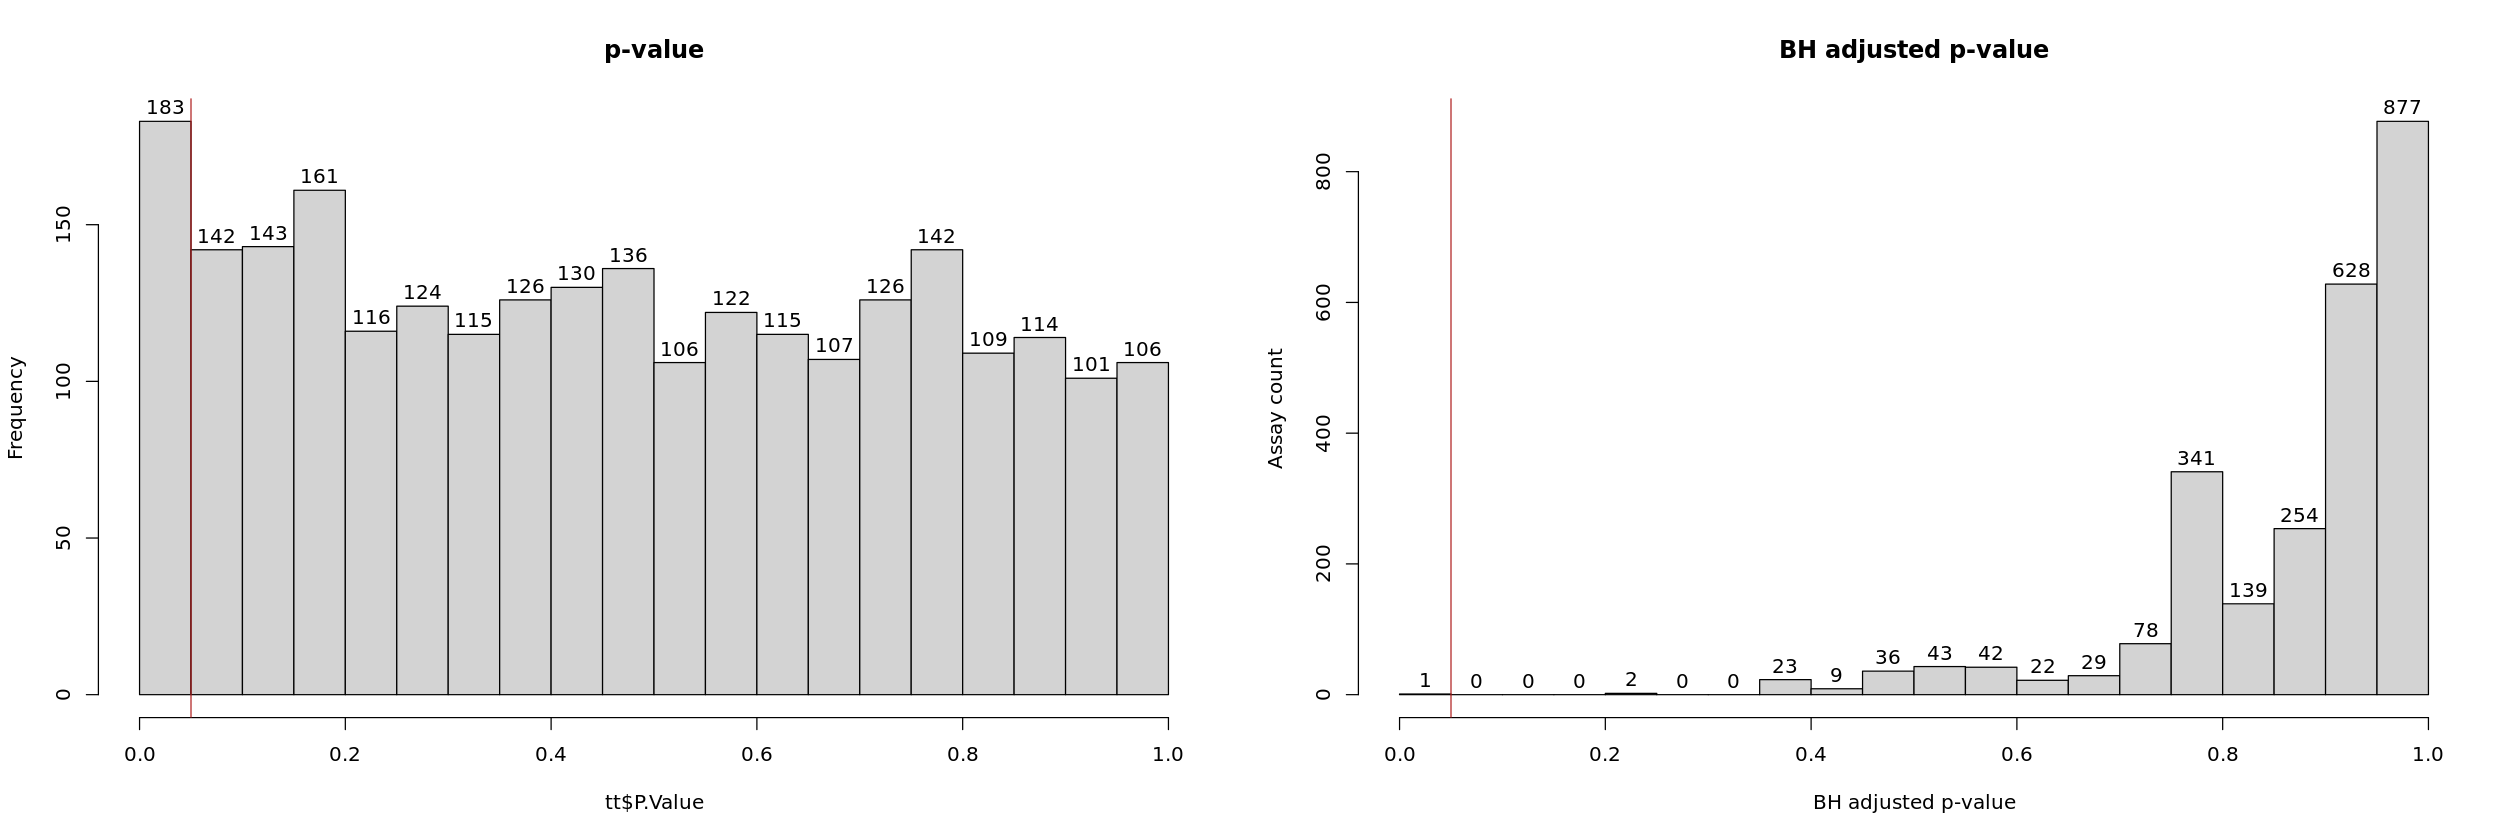

In [41]:
tt = tt[order(tt$adj.P.Val),]

tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)


options(repr.plot.width = 21, repr.plot.height = 7)
par(mfrow=c(1,2))
hist(tt$P.Value, breaks = 20, labels = TRUE, main = 'p-value')
abline(v=0.05, col='firebrick')
hist(tt$adj.P.Val, breaks = 20, labels = TRUE, main = 'BH adjusted p-value', xlab='BH adjusted p-value', ylab='Assay count')
abline(v=0.05, col='firebrick')

Warning message:
“Removed 2523 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


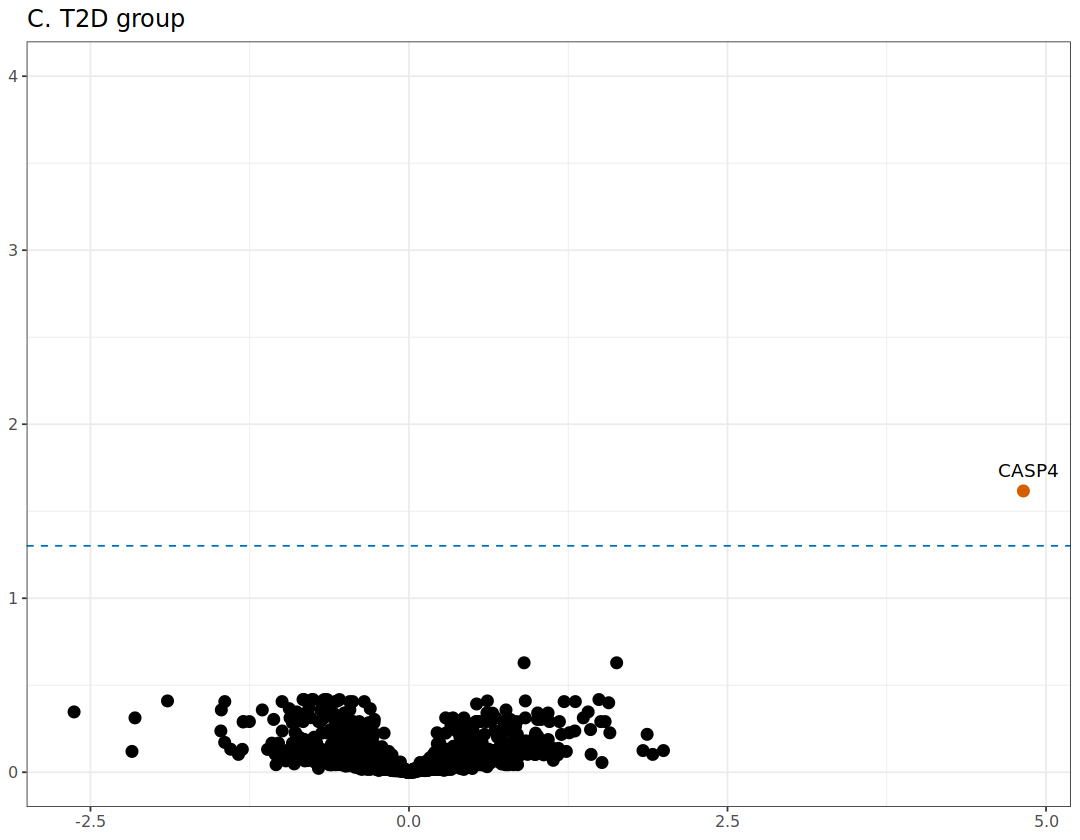

In [42]:
options(repr.plot.width=9, repr.plot.height=7)
sig.threshold = 0.05

tt2 = copy(tt)
prot_ids <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv", header = T, sep = ",")
tt2$OlinkID <- rownames(tt2)
tt2 <- inner_join(tt2, prot_ids, by = "OlinkID")
tt2$col='grey'
tt2[tt2$adj.P.Val<sig.threshold, 'col'] = 'black'

# Define significant points
# Create a column for coloring points
tt2 <- tt2 %>%
  mutate(
    col_sig = case_when(
      adj.P.Val < 0.05 & logFC > 0 ~ "red",
      adj.P.Val < 0.05 & logFC < 0 ~ "blue",
      TRUE ~ "black"
    ),
    label_point = ifelse(adj.P.Val < 0.05, Assay, NA)
  )

p2 <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = col_sig), size = 3, show.legend = FALSE) +
  geom_hline(
    yintercept = -log10(sig.threshold),
    linetype = "dashed",
    col = "#0072B2"      # Okabe–Ito blue
  ) +
  geom_text_repel(
    aes(label = label_point),
    box.padding = 0.5,
    point.padding = 0.5,
    segment.color = "black",
    show.legend = FALSE
  ) +
  labs(
    x = NULL,
    y = NULL,
    title = "C. T2D group"
  ) +
  theme_bw() +
  scale_color_manual(
    values = c(
      "red"   = "#D55E00",  # Vermillion (replaces red)
      "blue"  = "#0072B2",  # Okabe–Ito blue
      "black" = "#000000"   # Black
    )
  ) +
  theme(text = element_text(size = 12)) +
  coord_cartesian(ylim = c(0, 4))

print(p2)

In [44]:
#Info on 1 significant protein
rownames(tt_fdr005)
subset(assay.ids, assay.ids$OlinkID == rownames(tt_fdr005))

[1] "OID31276"

OlinkID,UniProt,Assay
<chr>,<chr>,<chr>
OID31276,P49662,CASP4


#### Prediabetic individuals

In [43]:
prediabetic_expression <- data.frame(prediabetic_expression)
rownames(prediabetic_expression) <- prediabetic_expression$SampleID
prediabetic_expression$SampleID <- NULL
expr_matrix <- as.matrix(t(prediabetic_expression))

In [44]:
prediabetic_covar <- data.frame(prediabetic_covar)
rownames(prediabetic_covar) <- prediabetic_covar$SampleID
prediabetic_covar$SampleID <- NULL

In [45]:
design = model.matrix(as.formula("~ MeanNPX + storage_time + timepoint"), data = prediabetic_covar)

In [46]:
dupcor <- duplicateCorrelation(expr_matrix, design, block=prediabetic_covar$SubjectID)
dupcor$consensus.correlation

[1] 0.5578021

In [47]:
#fitting the model
fitDupCor <- lmFit(expr_matrix, design, block=prediabetic_covar$SubjectID, correlation=dupcor$consensus)
fitDupCor <- eBayes(fitDupCor)

In [48]:
tt = topTable(fitDupCor, coef = "timepoint2", n = Inf, adjust.method="BH")
head(tt)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
OID20349,-0.7811953,-0.17693271,-5.353575,1.202798e-07,0.0003035862,7.0546404
OID30515,-0.6432794,-0.05022371,-4.947273,9.632003e-07,0.0012155587,5.2040516
OID20709,-0.5166558,-0.03662648,-4.451346,1.006440e-05,0.0069004633,3.1295000
OID21404,0.9795882,0.14390810,4.432932,1.093576e-05,0.0069004633,3.0563802
OID20207,-1.0343794,-0.04632866,-3.923396,9.674199e-05,0.0416604969,1.1463534
OID21247,0.6231000,0.16730794,3.835112,1.379066e-04,0.0416604969,0.8378402


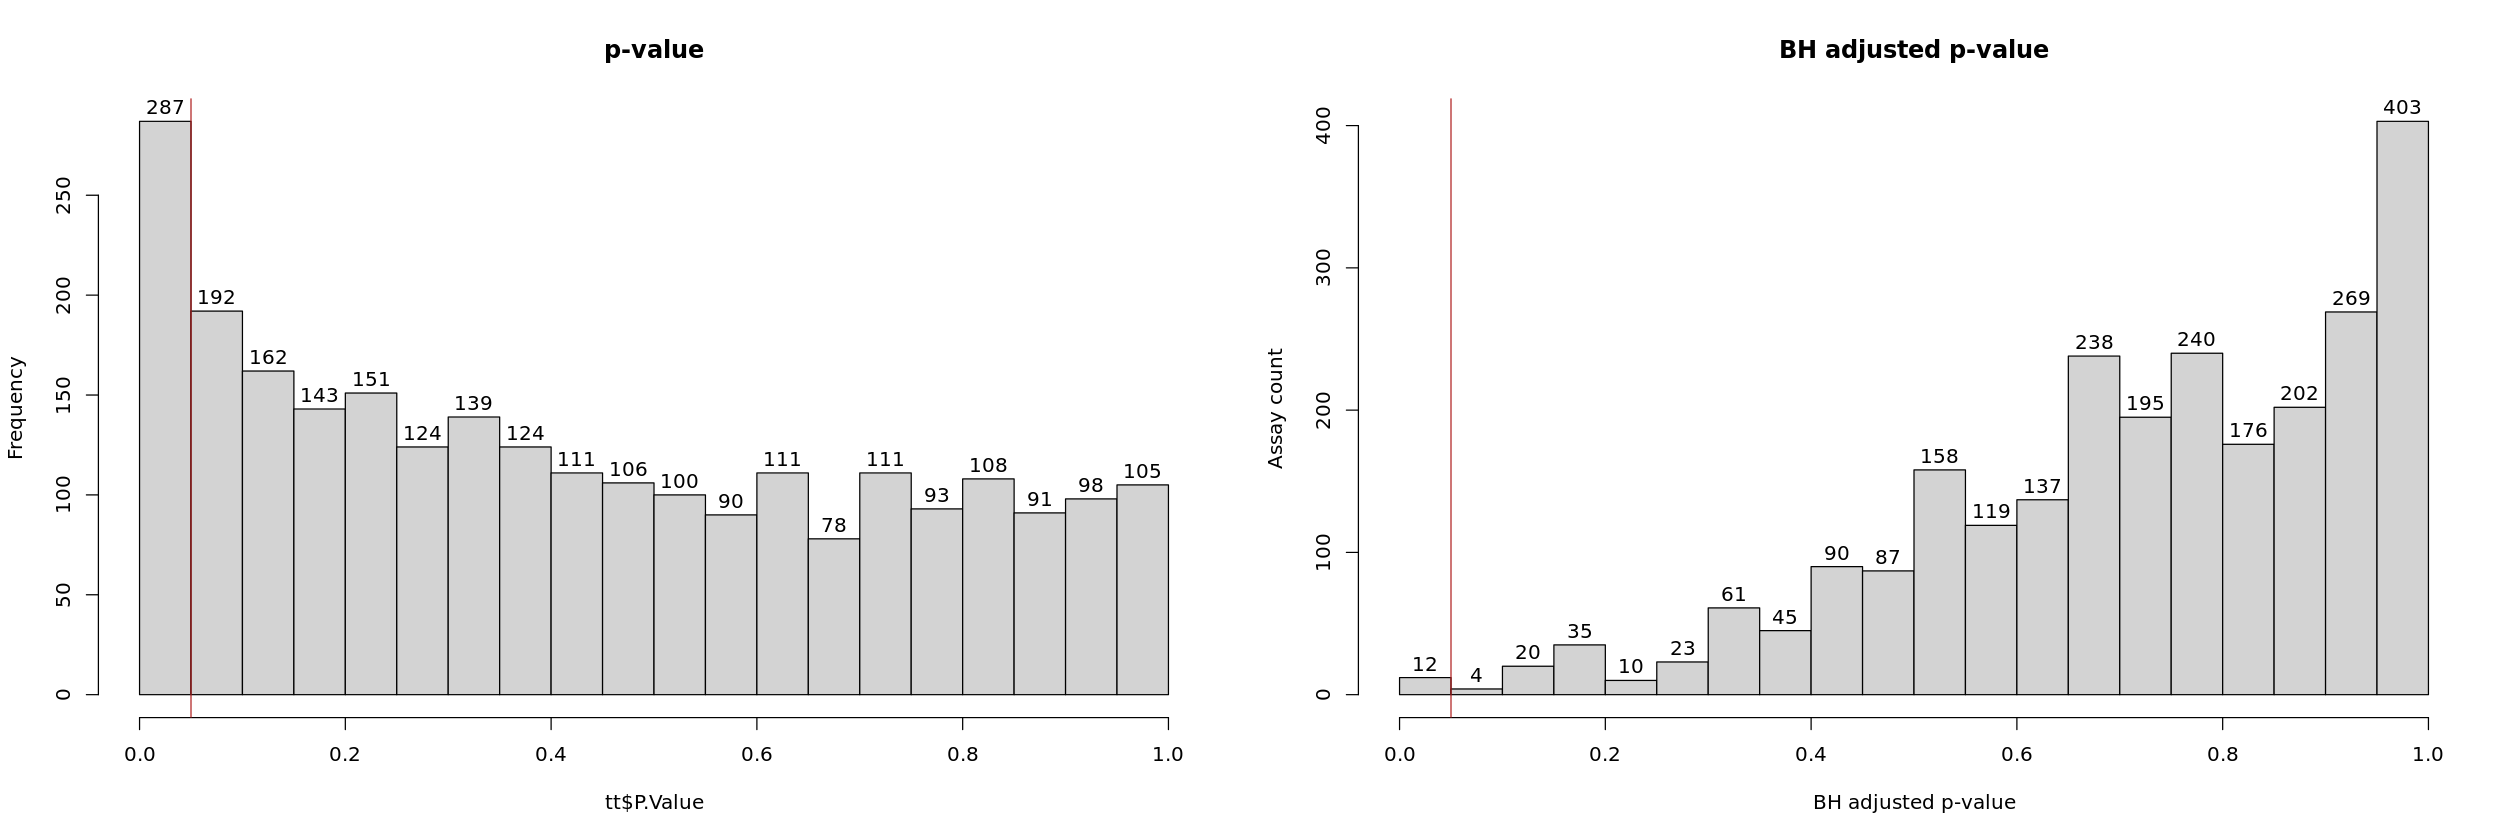

In [49]:
tt = tt[order(tt$adj.P.Val),]

tt_fdr005 = subset(tt, tt$adj.P.Val < 0.05)


options(repr.plot.width = 21, repr.plot.height = 7)
par(mfrow=c(1,2))
hist(tt$P.Value, breaks = 20, labels = TRUE, main = 'p-value')
abline(v=0.05, col='firebrick')
hist(tt$adj.P.Val, breaks = 20, labels = TRUE, main = 'BH adjusted p-value', xlab='BH adjusted p-value', ylab='Assay count')
abline(v=0.05, col='firebrick')

Warning message:
“Removed 2512 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


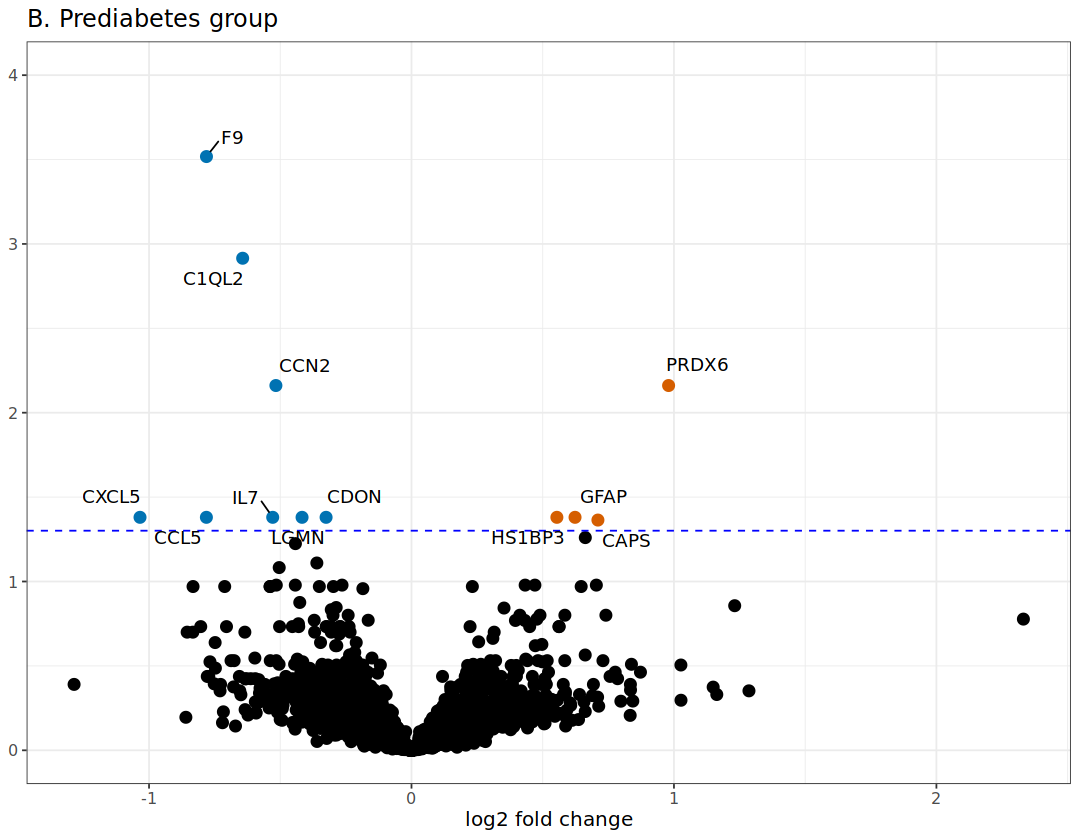

In [50]:
options(repr.plot.width=9, repr.plot.height=7)
sig.threshold = 0.05

tt2 = copy(tt)
tt2$col='grey'
tt2[tt2$adj.P.Val<sig.threshold, 'col'] = 'black'
prot_ids <- fread("/ictstr01/groups/itg/teams/zeggini/projects/PLIS/proteomics/QC/assay-info.csv", header = T, sep = ",")
tt2$OlinkID <- rownames(tt2)
tt2 <- inner_join(tt2, prot_ids, by = "OlinkID")
# Define significant points
# Create a column for coloring points
tt2 <- tt2 %>%
  mutate(
    col_sig = case_when(
      adj.P.Val < 0.05 & logFC > 0 ~ "red",
      adj.P.Val < 0.05 & logFC < 0 ~ "blue",
      TRUE ~ "black"
    ),
    label_point = ifelse(adj.P.Val < 0.05, Assay, NA)
  )
p3 <- ggplot(tt2, aes(x = logFC, y = -log10(adj.P.Val))) +
  geom_point(aes(color = col_sig), size = 3, show.legend = FALSE) +
  geom_hline(yintercept = -log10(sig.threshold), linetype = "dashed", col = "blue") +
  # Add labels with a circle
  geom_text_repel(aes(label = label_point), box.padding = 0.5, 
                  point.padding = 0.5, segment.color = "black", show.legend = FALSE) +
  labs(
    x = "log2 fold change",
    y = NULL,
    title = "B. Prediabetes group"
  ) +
  theme_bw() +
  scale_color_manual(values = c("red" = "#D55E00", "blue" = "#0072B2", "black" = "#000000")) +
  theme(text = element_text(size = 12)) +
  coord_cartesian(ylim = c(0, 4))
print(p3)

In [53]:
#Info on significant proteins
tt_fdr005_tmp <- tt_fdr005
tt_fdr005_tmp$OlinkID <- rownames(tt_fdr005_tmp)
tmp <- inner_join(tt_fdr005_tmp, assay.ids, by = "OlinkID")
upregulated <- subset(tmp, tmp$logFC > 0)
print(upregulated$Assay)
downregulated <- subset(tmp, tmp$logFC < 0)
print(downregulated$Assay)

[1] "PRDX6"  "GFAP"   "HS1BP3" "CAPS"  
[1] "F9"    "C1QL2" "CCN2"  "CXCL5" "IL7"   "CDON"  "LGMN"  "CCL5" 
